# Select Packages

To get started, let's select a few packages that we will need. In the **Packages** drop-down picker in the top right of the UI, search for and add the following packages by clicking on them:

- snowflake-ml-python
- seaborn
- matplotlib

Once you add the packages, click the **Start** button! Once it says **Active**, you're ready to run the rest of the Notebook.

## 2. ML Feature Transformations

- In this notebook, we will walk through a few transformations that are included in the Snowpark ML Preprocessing API. 
- We will also build a preprocessing pipeline to be used in the ML modeling notebook.

***Note: All feature transformations using Snowpark ML are distributed operations in the same way that Snowpark DataFrame operations are.***

### Import Libraries

In [1]:
# Snowpark for Python
from snowflake.snowpark import Session
from snowflake.snowpark.version import VERSION
import snowflake.snowpark.functions as F
from snowflake.snowpark.types import DecimalType

# Snowpark ML
import snowflake.ml.modeling.preprocessing as snowml
from snowflake.ml.modeling.pipeline import Pipeline
from snowflake.ml.modeling.metrics.correlation import correlation

# Data Science Libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Misc
import json
import joblib

# warning suppresion
import warnings; warnings.simplefilter('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Establish Secure Connection to Snowflake

Notebooks establish a Snowpark Session when the notebook is attached to the kernel. Let's use that Session object to validate our connection.

In [2]:
session = get_active_session()
session.sql_simplifier_enabled = True

snowflake_environment = session.sql('SELECT current_user(), current_version()').collect()
snowpark_version = VERSION

# Current Environment Details
print('\nConnection Established with the following parameters:')
print('User                        : {}'.format(snowflake_environment[0][0]))
print('Role                        : {}'.format(session.get_current_role()))
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Snowflake version           : {}'.format(snowflake_environment[0][1]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))


Connection Established with the following parameters:
User                        : SIKHADAS
Role                        : "ACCOUNTADMIN"
Database                    : "ML_HOL_DB"
Schema                      : "ML_HOL_SCHEMA"
Warehouse                   : "ML_HOL_WH"
Snowflake version           : 8.9.2
Snowpark for Python version : 1.12.0


In [3]:
# Specify the table name where we stored the diamonds dataset
# **nChange this only if you named your table something else in the data ingest notebook **
DEMO_TABLE = 'diamonds'
input_tbl = f"{session.get_current_database()}.{session.get_current_schema()}.{DEMO_TABLE}"

### Data Loading

In [4]:
# First, we read in the data from a Snowflake table into a Snowpark DataFrame
diamonds_df = session.table(input_tbl)

### Feature Transformations

We will illustrate a few of the transformation functions here, but the rest can be found in the [documentation](https://docs.snowflake.com/LIMITEDACCESS/snowflake-ml-preprocessing).

##### Let's use the `MinMaxScaler` to normalize the `CARAT` column.

In [5]:
# Normalize the CARAT column
snowml_mms = snowml.MinMaxScaler(input_cols=["CARAT"], output_cols=["CARAT_NORM"])
normalized_diamonds_df = snowml_mms.fit(diamonds_df).transform(diamonds_df)

# Reduce the number of decimals
new_col = normalized_diamonds_df.col("CARAT_NORM").cast(DecimalType(7, 6))
normalized_diamonds_df = normalized_diamonds_df.with_column("CARAT_NORM", new_col)

normalized_diamonds_df.show()

-------------------------------------------------------------------------------------------------------------------
|"COLOR"  |"CLARITY"  |"PRICE"  |"CUT"      |"CARAT"  |"X"   |"Y"   |"Z"   |"DEPTH"  |"TABLE_PCT"  |"CARAT_NORM"  |
-------------------------------------------------------------------------------------------------------------------
|E        |SI2        |326      |IDEAL      |0.23     |3.95  |3.98  |2.43  |61.5     |55.0         |0.006237      |
|E        |SI1        |326      |PREMIUM    |0.21     |3.89  |3.84  |2.31  |59.8     |61.0         |0.002079      |
|E        |VS1        |327      |GOOD       |0.23     |4.05  |4.07  |2.31  |56.9     |65.0         |0.006237      |
|I        |VS2        |334      |PREMIUM    |0.29     |4.2   |4.23  |2.63  |62.4     |58.0         |0.018711      |
|J        |SI2        |335      |GOOD       |0.31     |4.34  |4.35  |2.75  |63.3     |58.0         |0.022869      |
|J        |VVS2       |336      |VERY_GOOD  |0.24     |3.94  |3.96  |2.4

##### Let's use the `OrdinalEncoder` to transform `COLOR` and `CLARITY` from categorical to numerical values so they are more meaningful.

In [6]:
# Encode CUT and CLARITY preserve ordinal importance
categories = {
    "CUT": np.array(["IDEAL", "PREMIUM", "VERY_GOOD", "GOOD", "FAIR"]),
    "CLARITY": np.array(["IF", "VVS1", "VVS2", "VS1", "VS2", "SI1", "SI2", "I1", "I2", "I3"]),
}
snowml_oe = snowml.OrdinalEncoder(input_cols=["CUT", "CLARITY"], output_cols=["CUT_OE", "CLARITY_OE"], categories=categories)
ord_encoded_diamonds_df = snowml_oe.fit(normalized_diamonds_df).transform(normalized_diamonds_df)

# Show the encoding
print(snowml_oe._state_pandas)

ord_encoded_diamonds_df.show()

   _COLUMN_NAME  _CATEGORY  _INDEX
0           CUT      IDEAL       0
1           CUT    PREMIUM       1
2           CUT  VERY_GOOD       2
3           CUT       GOOD       3
4           CUT       FAIR       4
5       CLARITY         IF       0
6       CLARITY       VVS1       1
7       CLARITY       VVS2       2
8       CLARITY        VS1       3
9       CLARITY        VS2       4
10      CLARITY        SI1       5
11      CLARITY        SI2       6
12      CLARITY         I1       7
13      CLARITY         I2       8
14      CLARITY         I3       9
---------------------------------------------------------------------------------------------------------------------------------------------
|"CUT_OE"  |"CLARITY_OE"  |"COLOR"  |"CLARITY"  |"PRICE"  |"CUT"      |"CARAT"  |"X"   |"Y"   |"Z"   |"DEPTH"  |"TABLE_PCT"  |"CARAT_NORM"  |
---------------------------------------------------------------------------------------------------------------------------------------------
|0.0       |6.

##### Let's use the `OneHotEncoder` to transform the categorical columns to numerical columns.

This is more for illustration purposes. Using the OrdinalEncoder makes more sense for the diamonds dataset since `CARAT`, `COLOR`, and `CLARITY` all follow a natural ranking order.

In [7]:
# Encode categoricals to numeric columns
snowml_ohe = snowml.OneHotEncoder(input_cols=["CUT", "COLOR", "CLARITY"], output_cols=["CUT_OHE", "COLOR_OHE", "CLARITY_OHE"])
transformed_diamonds_df = snowml_ohe.fit(ord_encoded_diamonds_df).transform(ord_encoded_diamonds_df)

np.array(transformed_diamonds_df.columns)

array(['CUT_OHE_FAIR', 'CUT_OHE_GOOD', 'CUT_OHE_IDEAL', 'CUT_OHE_PREMIUM',
       'CUT_OHE_VERY_GOOD', 'COLOR_OHE_D', 'COLOR_OHE_E', 'COLOR_OHE_F',
       'COLOR_OHE_G', 'COLOR_OHE_H', 'COLOR_OHE_I', 'COLOR_OHE_J',
       'CLARITY_OHE_I1', 'CLARITY_OHE_IF', 'CLARITY_OHE_SI1',
       'CLARITY_OHE_SI2', 'CLARITY_OHE_VS1', 'CLARITY_OHE_VS2',
       'CLARITY_OHE_VVS1', 'CLARITY_OHE_VVS2', 'CUT_OE', 'CLARITY_OE',
       'COLOR', 'CLARITY', 'PRICE', 'CUT', 'CARAT', 'X', 'Y', 'Z',
       'DEPTH', 'TABLE_PCT', 'CARAT_NORM'], dtype='<U17')

##### Finally, we can also build out a full preprocessing `Pipeline`.

This will be useful for both the ML training & inference steps to have standarized feature transformations.

In [8]:
# Categorize all the features for processing
CATEGORICAL_COLUMNS = ["CUT", "COLOR", "CLARITY"]
CATEGORICAL_COLUMNS_OE = ["CUT_OE", "COLOR_OE", "CLARITY_OE"] # To name the ordinal encoded columns
NUMERICAL_COLUMNS = ["CARAT", "DEPTH", "TABLE_PCT", "X", "Y", "Z"]

categories = {
    "CUT": np.array(["IDEAL", "PREMIUM", "VERY_GOOD", "GOOD", "FAIR"]),
    "CLARITY": np.array(["IF", "VVS1", "VVS2", "VS1", "VS2", "SI1", "SI2", "I1", "I2", "I3"]),
    "COLOR": np.array(['D', 'E', 'F', 'G', 'H', 'I', 'J']),
}

In [9]:
# Build the pipeline
preprocessing_pipeline = Pipeline(
    steps=[
            (
                "OE",
                snowml.OrdinalEncoder(
                    input_cols=CATEGORICAL_COLUMNS,
                    output_cols=CATEGORICAL_COLUMNS_OE,
                    categories=categories,
                )
            ),
            (
                "MMS",
                snowml.MinMaxScaler(
                    clip=True,
                    input_cols=NUMERICAL_COLUMNS,
                    output_cols=NUMERICAL_COLUMNS,
                )
            )
    ]
)

PIPELINE_FILE = '/tmp/preprocessing_pipeline.joblib'
joblib.dump(preprocessing_pipeline, PIPELINE_FILE) # We are just pickling it locally first

transformed_diamonds_df = preprocessing_pipeline.fit(diamonds_df).transform(diamonds_df)
transformed_diamonds_df.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CARAT"               |"DEPTH"              |"TABLE_PCT"          |"X"                  |"Y"                  |"Z"                  |"CUT_OE"  |"COLOR_OE"  |"CLARITY_OE"  |"COLOR"  |"CLARITY"  |"PRICE"  |"CUT"      |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|0.006237006237006237  |0.5138888888888888   |0.23076923076923073  |0.3677839851024209   |0.06757215619694397  |0.07641509433962265  |0.0       |1.0         |6.0           |E        |SI2        |326      |IDEAL      |
|0.002079002079002079  |0.46666666666666656  |0.34615384615384615  |0.36219739292364994  |0.06519524617996604  |0.07264150943396

In [10]:
# You can also save the pickled object into the stage we created earlier for deployment
session.file.put(PIPELINE_FILE, "@ML_HOL_ASSETS", overwrite=True)

[PutResult(source='preprocessing_pipeline.joblib', target='preprocessing_pipeline.joblib.gz', source_size=2068, target_size=1120, source_compression='NONE', target_compression='GZIP', status='UPLOADED', message='')]

### Data Exploration

Now that we've transformed our features, let's calculate the correlation using Snowpark ML's `correlation()` function between each pair to better understand their relationships.

*Note: Snowpark ML's pearson correlation function returns a Pandas DataFrame*

In [11]:
corr_diamonds_df = correlation(df=transformed_diamonds_df)
corr_diamonds_df # This is a Pandas DataFrame

The version of package 'numpy' in the local environment is 1.26.4, which does not fit the criteria for the requirement 'numpy'. Your UDF might not work when the package version is different between the server and your local environment.
The version of package 'numpy' in the local environment is 1.26.4, which does not fit the criteria for the requirement 'numpy'. Your UDF might not work when the package version is different between the server and your local environment.


,CARAT,DEPTH,TABLE_PCT,X,Y,Z,CUT_OE,COLOR_OE,CLARITY_OE,PRICE
CARAT,1.000000,0.028224,0.181618,0.975094,0.951722,0.953387,0.134967,0.291437,0.352841,0.921591
DEPTH,0.028224,1.000000,-0.295779,-0.025289,-0.029341,0.094924,0.218055,0.047279,0.067384,-0.010647
TABLE_PCT,0.181618,-0.295779,1.000000,0.195344,0.183760,0.150929,0.433405,0.026465,0.160327,0.127134
X,0.975094,-0.025289,0.195344,1.000000,0.974701,0.970772,0.125565,0.270287,0.371999,0.884435
Y,0.951722,-0.029341,0.183760,0.974701,1.000000,0.952006,0.121462,0.263584,0.358420,0.865421
Z,0.953387,0.094924,0.150929,0.970772,0.952006,1.000000,0.149323,0.268227,0.366952,0.861249
CUT_OE,0.134967,0.218055,0.433405,0.125565,0.121462,0.149323,1.000000,0.020519,0.189175,0.053491
COLOR_OE,0.291437,0.047279,0.026465,0.270287,0.263584,0.268227,0.020519,1.000000,-0.025631,0.172511
CLARITY_OE,0.352841,0.067384,0.160327,0.371999,0.358420,0.366952,0.189175,-0.025631,1.000000,0.146800
PRICE,0.921591,-0.010647,0.127134,0.884435,0.865421,0.861249,0.053491,0.172511,0.146800,1.000000


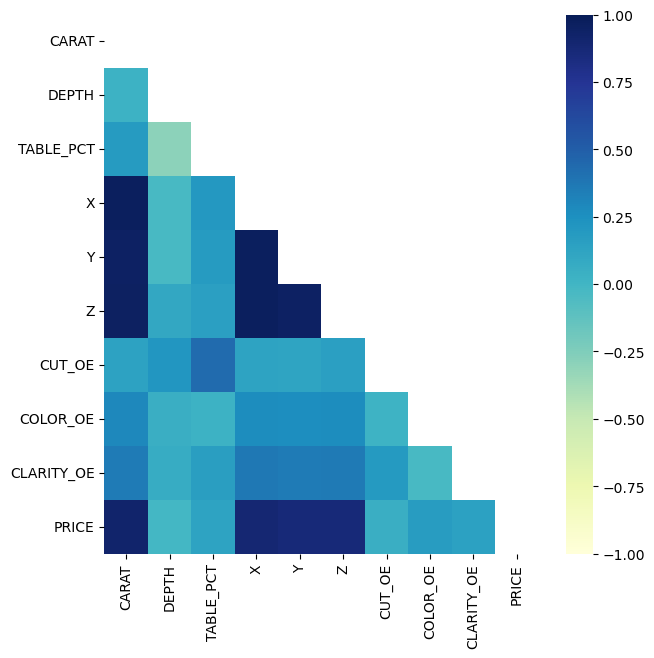

In [12]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_diamonds_df, dtype=bool))

# Create a heatmap with the features
plt.figure(figsize=(7, 7))
heatmap = sns.heatmap(corr_diamonds_df, mask=mask, cmap="YlGnBu", annot=True, vmin=-1, vmax=1)

We note that `CARAT` and `PRICE` are highly correlated, which makes sense! Let's take a look at their relationship a bit closer.

*Note: You will have to convert your Snowpark DF to a Pandas DF in order to use matplotlib & seaborn.*

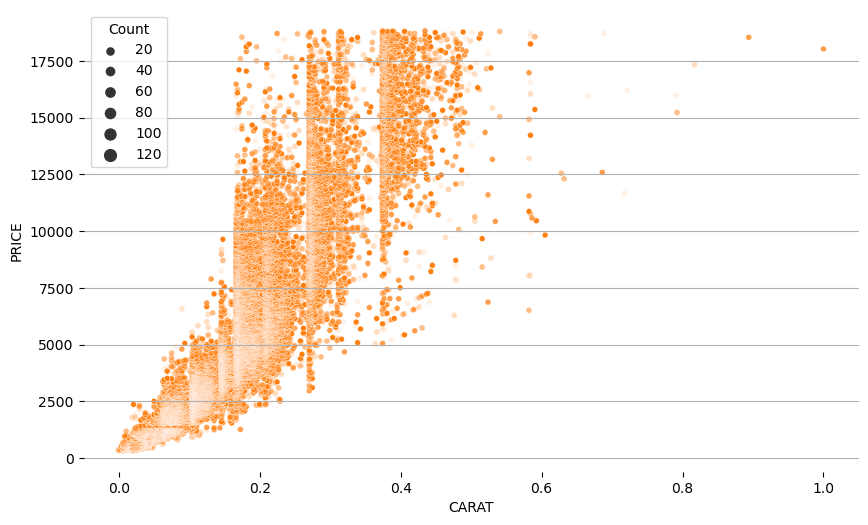

In [13]:
# Set up a plot to look at CARAT and PRICE
counts = transformed_diamonds_df.to_pandas().groupby(['PRICE', 'CARAT']).size().reset_index(name='Count')

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.scatterplot(data=counts, x='CARAT', y='PRICE', size='Count', markers='o', alpha=(0.1, .25, 0.5, 0.75, 1))
ax.grid(axis='y')

# The relationship is not linear - it appears exponential which makes sense given the rarity of the large diamonds
sns.move_legend(ax, "upper left")
sns.despine(left=True, bottom=True)